In [2]:
import sys
import os
from time import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn. ensemble import RandomForestClassifier
import xgboost as xgb

In [3]:
# Some Basic Parameters for housekeeping

# set location of input files:
inpDir = os.path.join('..', '..', 'input')

# set location of inputs for this module
moduleDir = 'machine_learning'

# set location of output files
outDir = os.path.join('..', 'output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.1
N_SAMPLES = 1000


# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.rainbow
plt.rcParams.update(params);
plt.set_cmap(CMAP);



TEST_SIZE = 0.2
plt.style.use('seaborn-v0_8-darkgrid')

<Figure size 1500x500 with 0 Axes>

In [4]:
data_df= pd.read_csv('SANTANDER/train.csv')

In [5]:
data_df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [6]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,76020.0,75964.050723,43781.947379,1.00,38104.7500,76043.00,113748.7500,151838.00
var3,76020.0,-1523.199277,39033.462364,-999999.00,2.0000,2.00,2.0000,238.00
var15,76020.0,33.212865,12.956486,5.00,23.0000,28.00,40.0000,105.00
imp_ent_var16_ult1,76020.0,86.208265,1614.757313,0.00,0.0000,0.00,0.0000,210000.00
imp_op_var39_comer_ult1,76020.0,72.363067,339.315831,0.00,0.0000,0.00,0.0000,12888.03
...,...,...,...,...,...,...,...,...
saldo_medio_var44_hace3,76020.0,1.858575,147.786584,0.00,0.0000,0.00,0.0000,24650.01
saldo_medio_var44_ult1,76020.0,76.026165,4040.337842,0.00,0.0000,0.00,0.0000,681462.90
saldo_medio_var44_ult3,76020.0,56.614351,2852.579397,0.00,0.0000,0.00,0.0000,397884.30
var38,76020.0,117235.809430,182664.598503,5163.75,67870.6125,106409.16,118756.2525,22034738.76


In [7]:
data_df.TARGET.value_counts()

TARGET
0    73012
1     3008
Name: count, dtype: int64

In [8]:
class_names = data_df.TARGET.unique()
class_names

array([0, 1], dtype=int64)

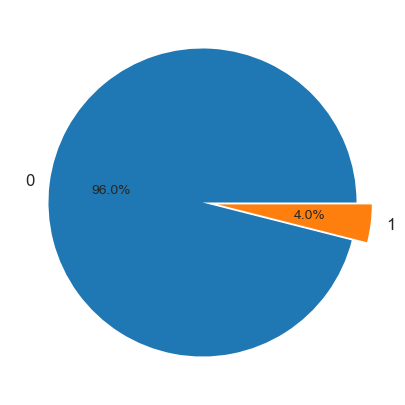

In [9]:
fig, ax = plt.subplots(figsize= (5,5))
explode = (0,0.1)
ax.pie(data_df['TARGET'].value_counts(),explode=explode, labels= class_names, autopct='%1.1f%%');

In [10]:
for col in data_df.columns:
    print(f'{col}:{len(data_df[col].unique())}:{data_df[col].unique()}')

ID:76020:[     1      3      4 ... 151835 151836 151838]
var3:208:[      2     229     178       0       8       3       4      10     110
       7     177       1       6     137      17 -999999      13      14
     148       5      11      15     122      22       9      58     121
      12     127      33     125     209      72      31      51      16
     107     174     141     191     104     129      18      49      73
      94     131     219     187     114      28      89     115      53
     126      47      84     235     161     197      23      30     146
     158     138      26     120      66     216     215      90      20
      21     103     192     142      29     163     223      95      98
      38     156      97     105     150     183     184      52      54
     220      25     225      86     124      27     162      19     195
     218      24      60     108      82      36     102     175     144
     169      64     201      79      91     159     135  

In [11]:
data_df.isnull().sum()

ID                         0
var3                       0
var15                      0
imp_ent_var16_ult1         0
imp_op_var39_comer_ult1    0
                          ..
saldo_medio_var44_hace3    0
saldo_medio_var44_ult1     0
saldo_medio_var44_ult3     0
var38                      0
TARGET                     0
Length: 371, dtype: int64

In [12]:
data_df['n0']= (data_df==0).sum(axis=1)
data_df.shape

(76020, 372)

In [13]:
drop_col = []
for col in data_df.columns:
    if data_df[col].std()==0:
        drop_col.append(col)

In [14]:
drop_col.append('ID')

In [15]:
data_df.drop(drop_col,axis=1, inplace = True)

In [16]:
drop_col=[]
cols= data_df.columns
for i in range(len(cols)-1):
    v= data_df[cols[i]].values
   
    for j in range(i+1, len(cols)):
        if np.array_equal(v, data_df[cols[j]].values):
            drop_col.append(cols[j])
len(drop_col)

29

In [17]:
data_df.drop(drop_col,axis=1, inplace = True)

In [18]:
data_df.isnull().sum().sum()

0

In [19]:
feature_df = data_df.drop('TARGET', axis=1)
labels= data_df[['TARGET']]

In [20]:
num_cols= feature_df.describe().columns.to_list()
len(num_cols)

307

In [72]:
from_range = 150
to_range=175
feature_df[num_cols[from_range:to_range]].describe().T

,count,mean,std,min,25%,50%,75%,max
saldo_var42,76020.0,7.191725e+03,4.914531e+04,-4942.26,0.0,3.0,120.0,3.008077e+06
saldo_var44,76020.0,9.635274e+01,5.218428e+03,0.00,0.0,0.0,0.0,7.400066e+05
var36,76020.0,4.044908e+01,4.736272e+01,0.00,2.0,3.0,99.0,9.900000e+01
delta_imp_amort_var18_1y3,76020.0,2.630887e+05,5.129183e+07,0.00,0.0,0.0,0.0,1.000000e+10
delta_imp_amort_var34_1y3,76020.0,2.630887e+05,5.129183e+07,0.00,0.0,0.0,0.0,1.000000e+10
delta_imp_aport_var13_1y3,76020.0,4.867140e+07,6.959537e+08,-1.00,0.0,0.0,0.0,1.000000e+10
delta_imp_aport_var17_1y3,76020.0,5.130229e+06,2.264435e+08,-1.00,0.0,0.0,0.0,1.000000e+10
delta_imp_aport_var33_1y3,76020.0,1.315443e+05,3.626904e+07,-1.00,0.0,0.0,0.0,1.000000e+10
delta_imp_compra_var44_1y3,76020.0,9.208103e+06,3.033108e+08,-1.00,0.0,0.0,0.0,1.000000e+10
delta_imp_reemb_var13_1y3,76020.0,4.998685e+06,2.235230e+08,0.00,0.0,0.0,0.0,1.000000e+10


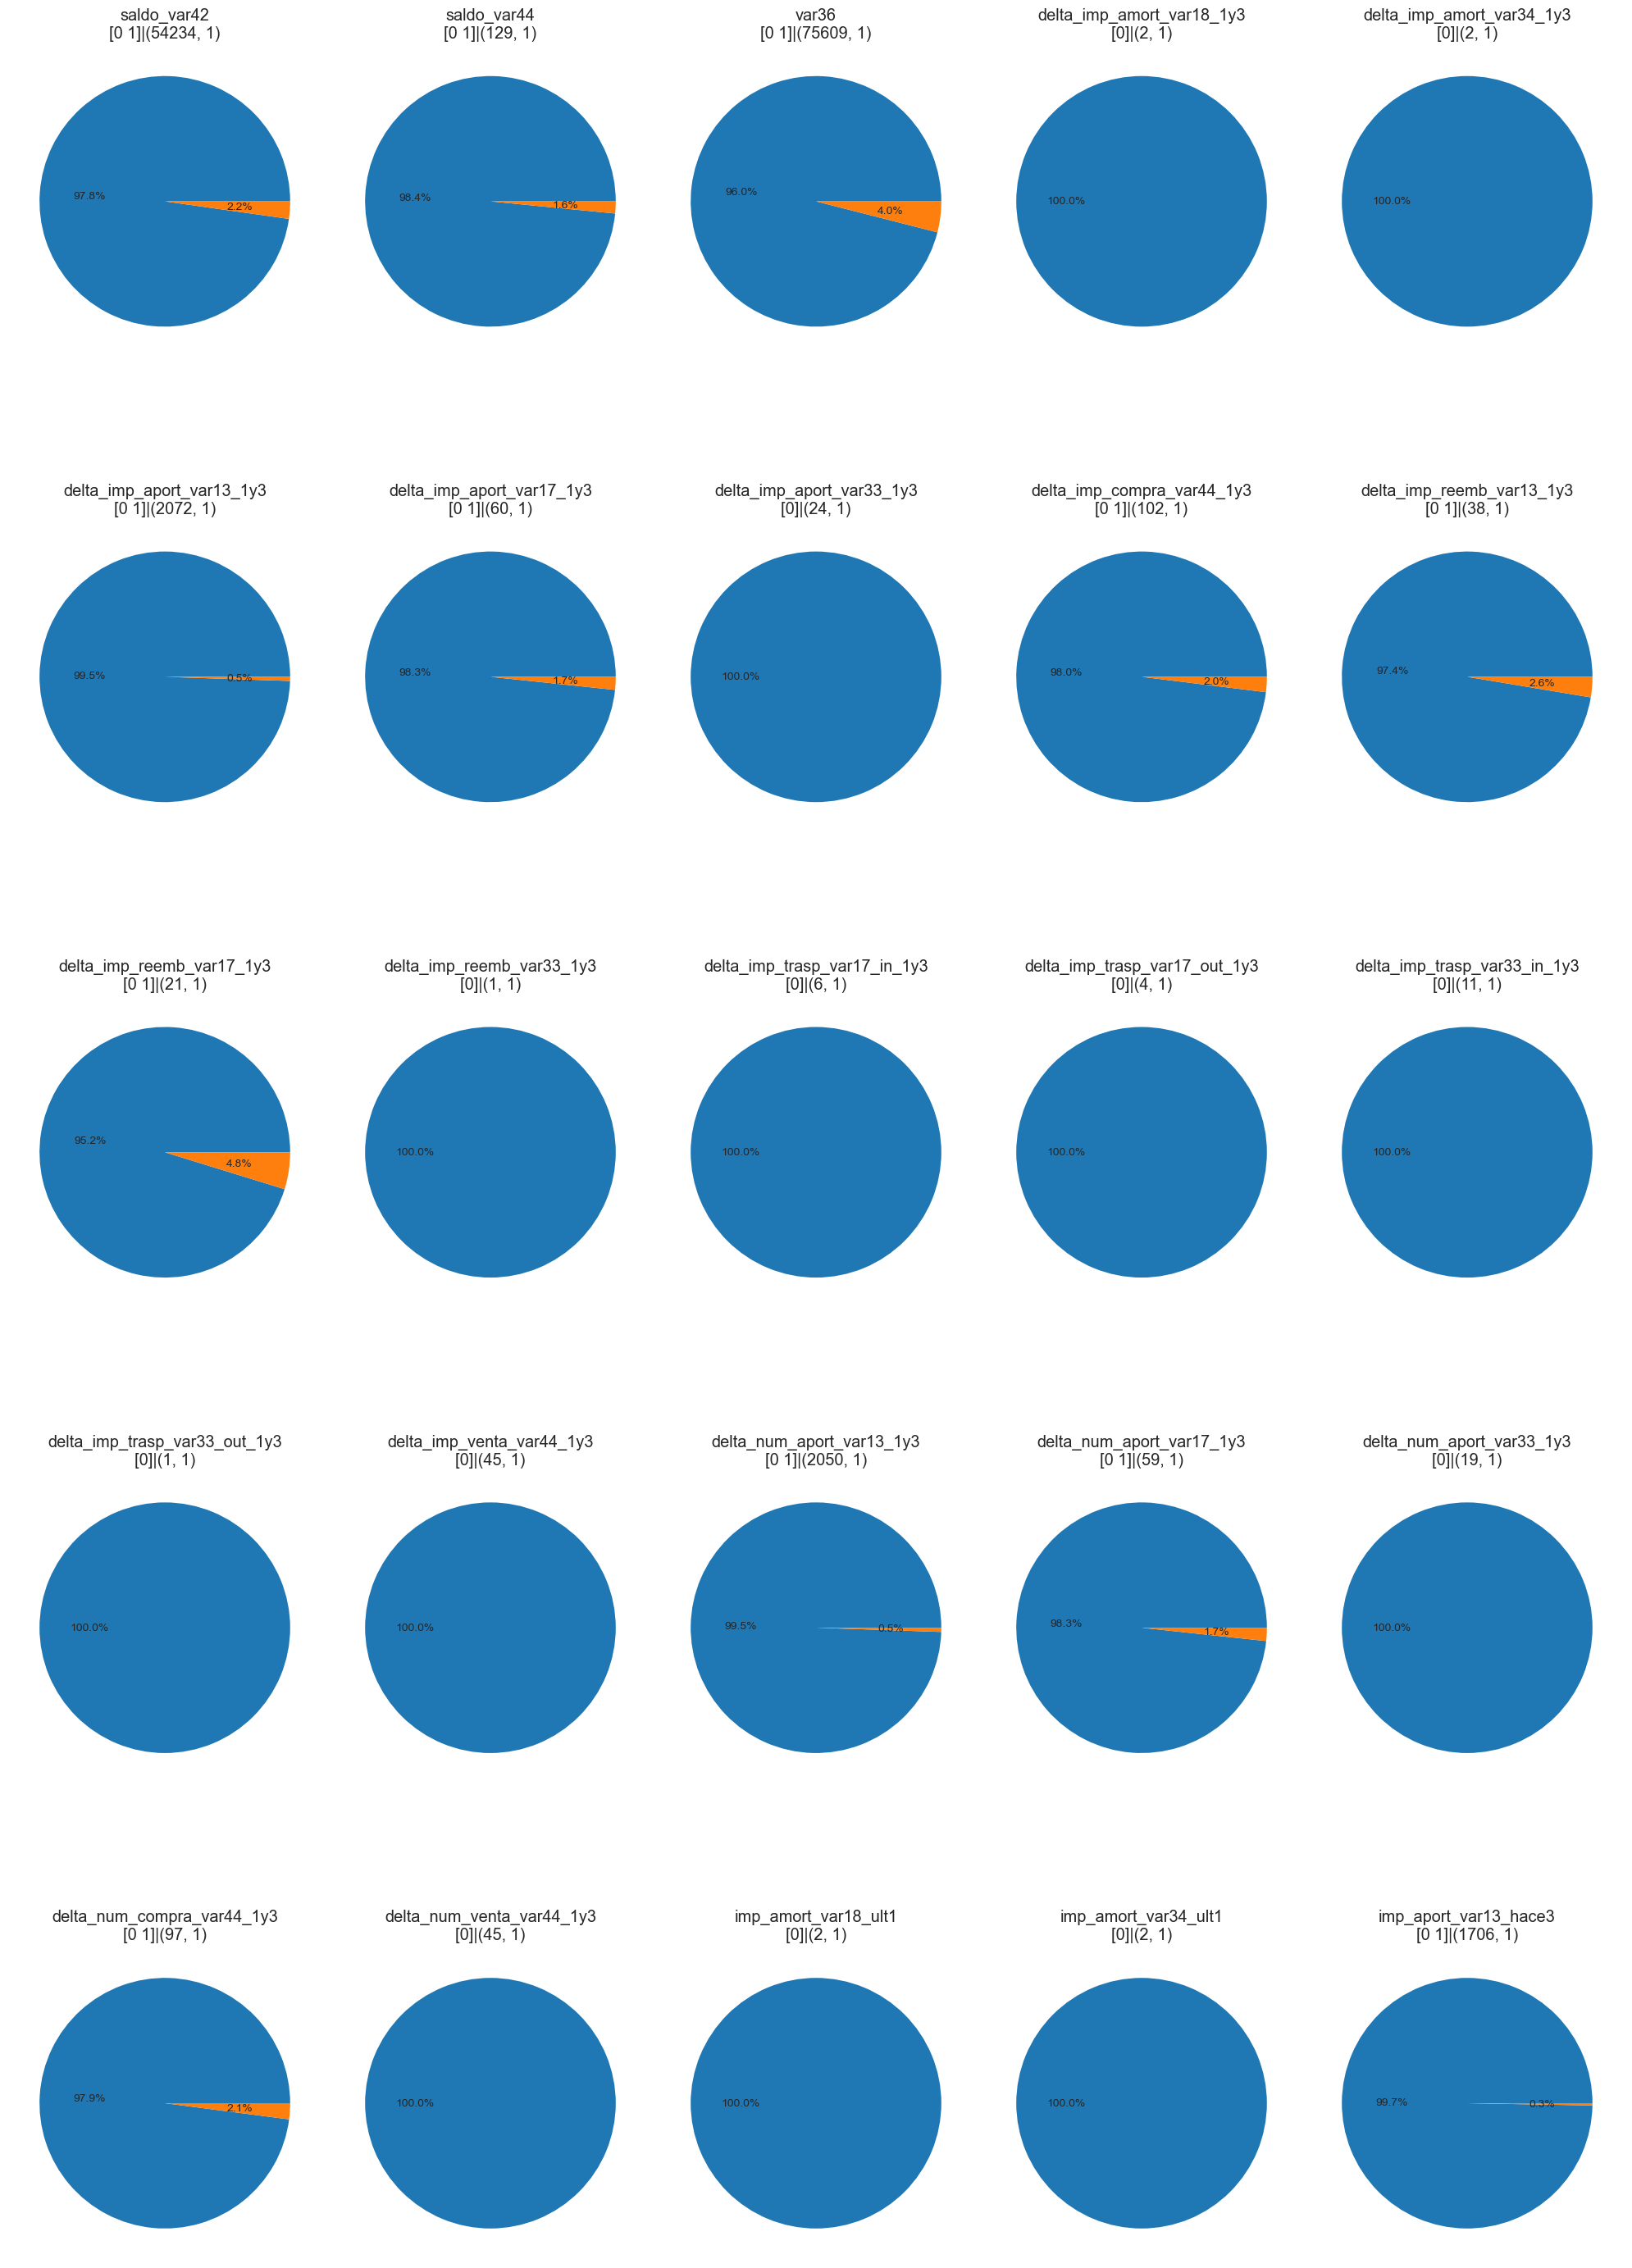

In [82]:
fig,axes= plt.subplots(5,5, figsize=(20,30))
axes = axes.ravel()
for count , col in enumerate(num_cols[from_range:to_range]):
    ax=axes[count]
    tmp_df= labels[feature_df[col]!=0]
    u_title=tmp_df['TARGET'].unique()
    shape=tmp_df.shape
    ax.pie(tmp_df['TARGET'].value_counts(), autopct='%1.1f%%')
    ax.set_title(f'{col}\n{u_title}|{shape}')
plt.tight_layout()

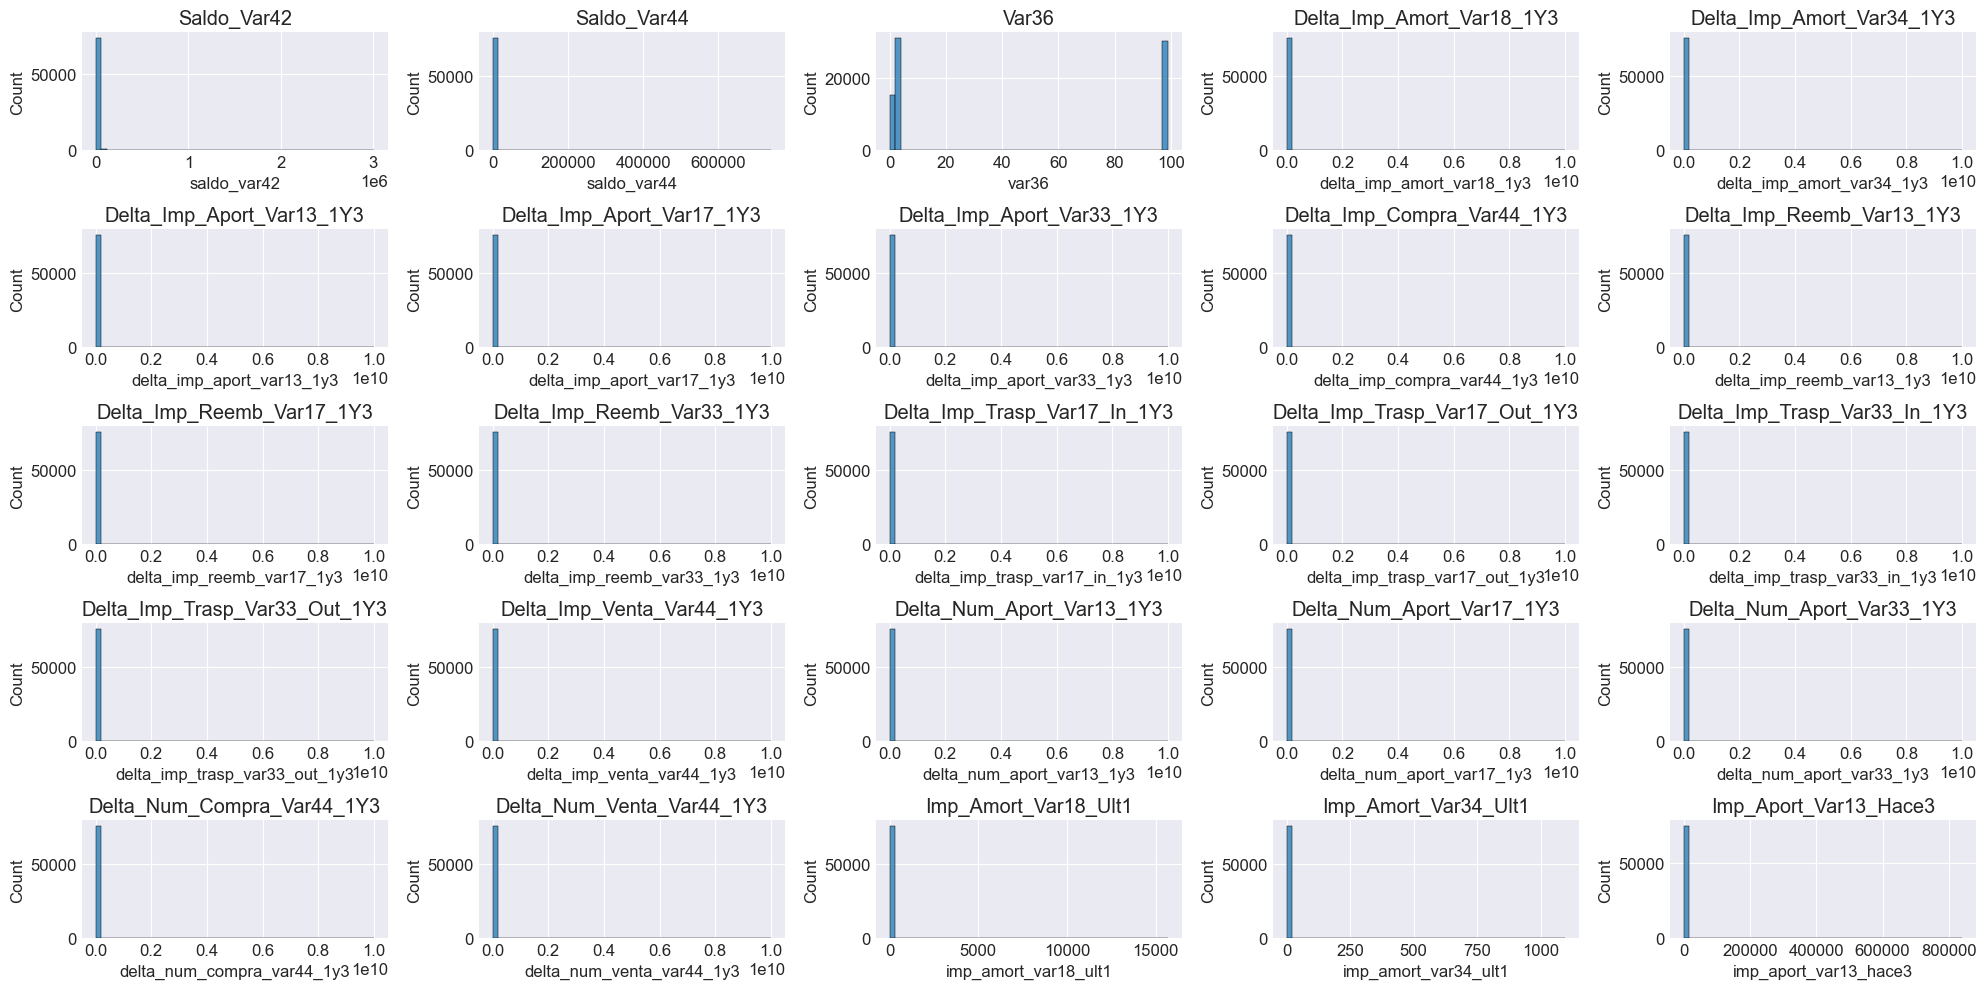

In [70]:
fig,axes= plt.subplots(5,5, figsize=(20,10))
axes = axes.ravel()
for count , col in enumerate(num_cols[from_range:to_range]):
    ax=axes[count]
    sns.histplot(feature_df, x=col, ax=ax , bins=50)
    ax.set_title(col.title())
plt.tight_layout()

In [84]:
from_range = 175
to_range=200
feature_df[num_cols[from_range:to_range]].describe().T

,count,mean,std,min,25%,50%,75%,max
imp_aport_var13_ult1,76020.0,619.585010,11252.995089,0.0,0.0,0.0,0.0,450000.00
imp_aport_var17_hace3,76020.0,98.788769,22120.719164,0.0,0.0,0.0,0.0,6083691.87
imp_aport_var17_ult1,76020.0,31.105323,2457.091282,0.0,0.0,0.0,0.0,432457.32
imp_aport_var33_hace3,76020.0,2.985793,226.862984,0.0,0.0,0.0,0.0,36000.00
imp_aport_var33_ult1,76020.0,0.048145,6.022692,0.0,0.0,0.0,0.0,1260.00
imp_var7_emit_ult1,76020.0,2.721454,554.249437,0.0,0.0,0.0,0.0,145384.92
imp_var7_recib_ult1,76020.0,127.698210,6368.996731,0.0,0.0,0.0,0.0,1039260.00
imp_compra_var44_hace3,76020.0,13.964581,1151.510862,0.0,0.0,0.0,0.0,210001.35
imp_compra_var44_ult1,76020.0,116.782528,13620.442172,0.0,0.0,0.0,0.0,3410058.66
imp_reemb_var13_ult1,76020.0,46.180243,2859.736591,0.0,0.0,0.0,0.0,450000.00


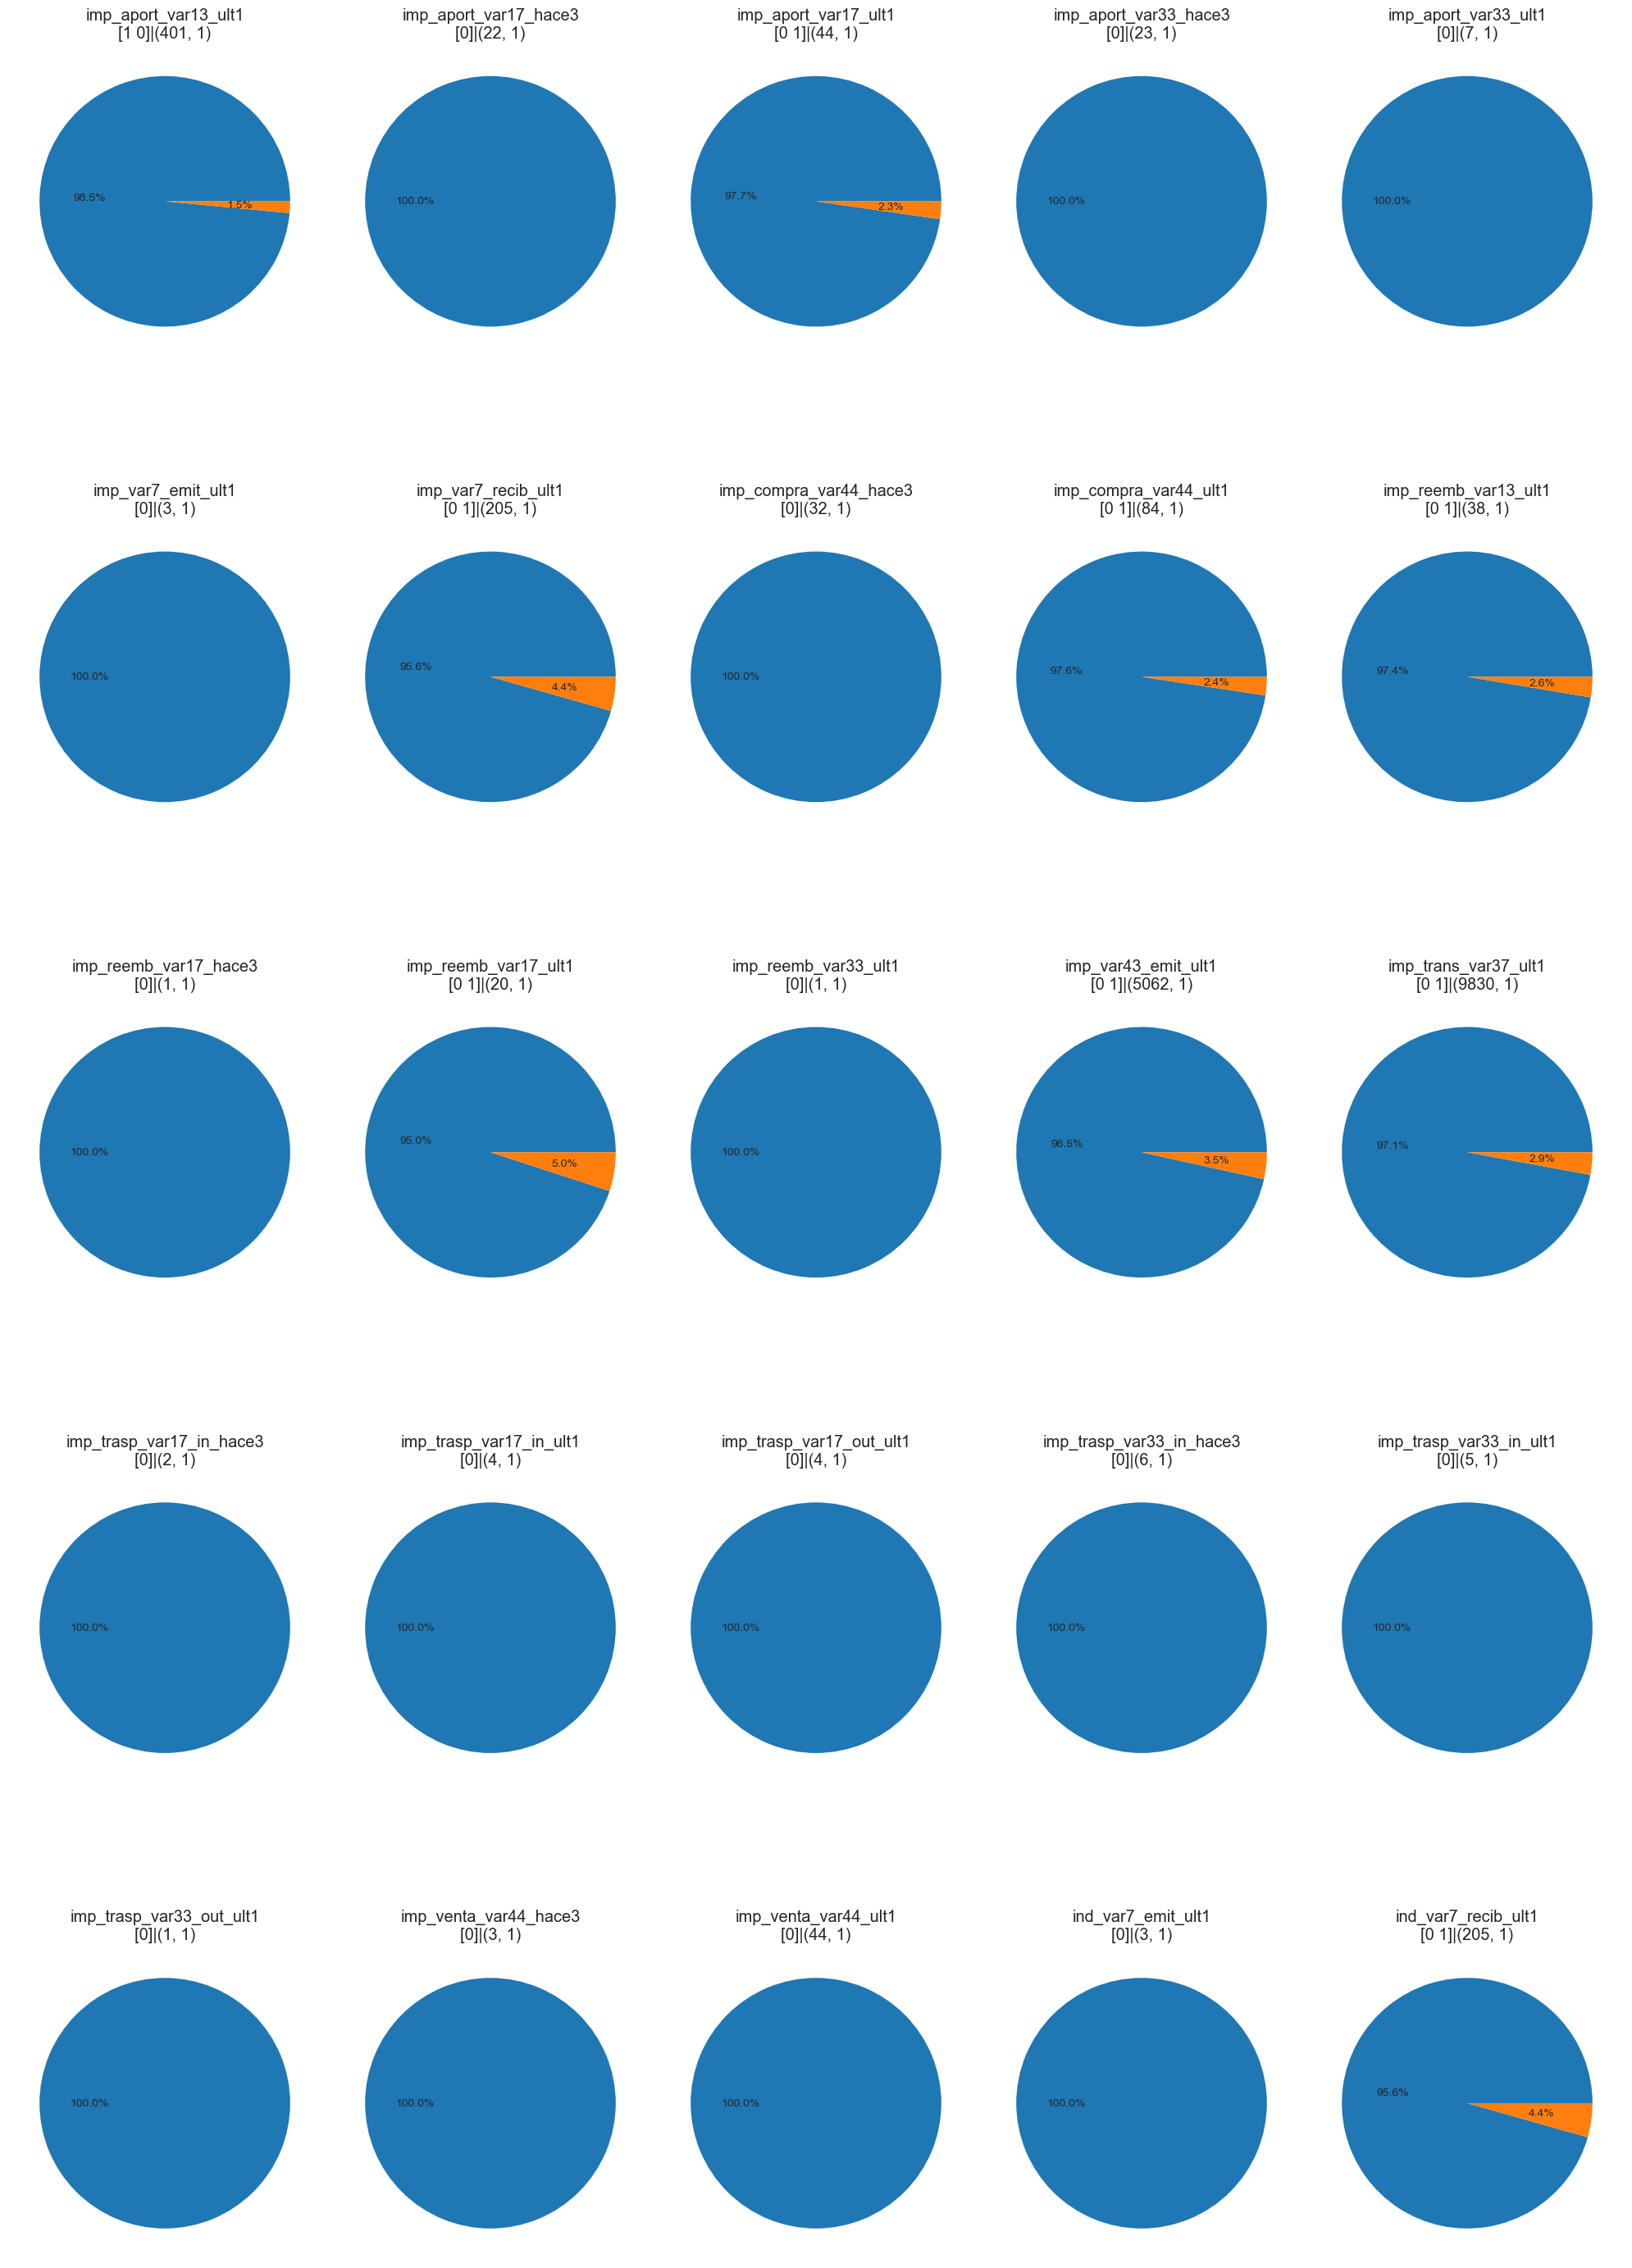

In [86]:
fig,axes= plt.subplots(5,5, figsize=(20,30))
axes = axes.ravel()
for count , col in enumerate(num_cols[from_range:to_range]):
    ax=axes[count]
    tmp_df= labels[feature_df[col]!=0]
    u_title=tmp_df['TARGET'].unique()
    shape=tmp_df.shape
    ax.pie(tmp_df['TARGET'].value_counts(), autopct='%1.1f%%')
    ax.set_title(f'{col}\n{u_title}|{shape}')
plt.tight_layout()

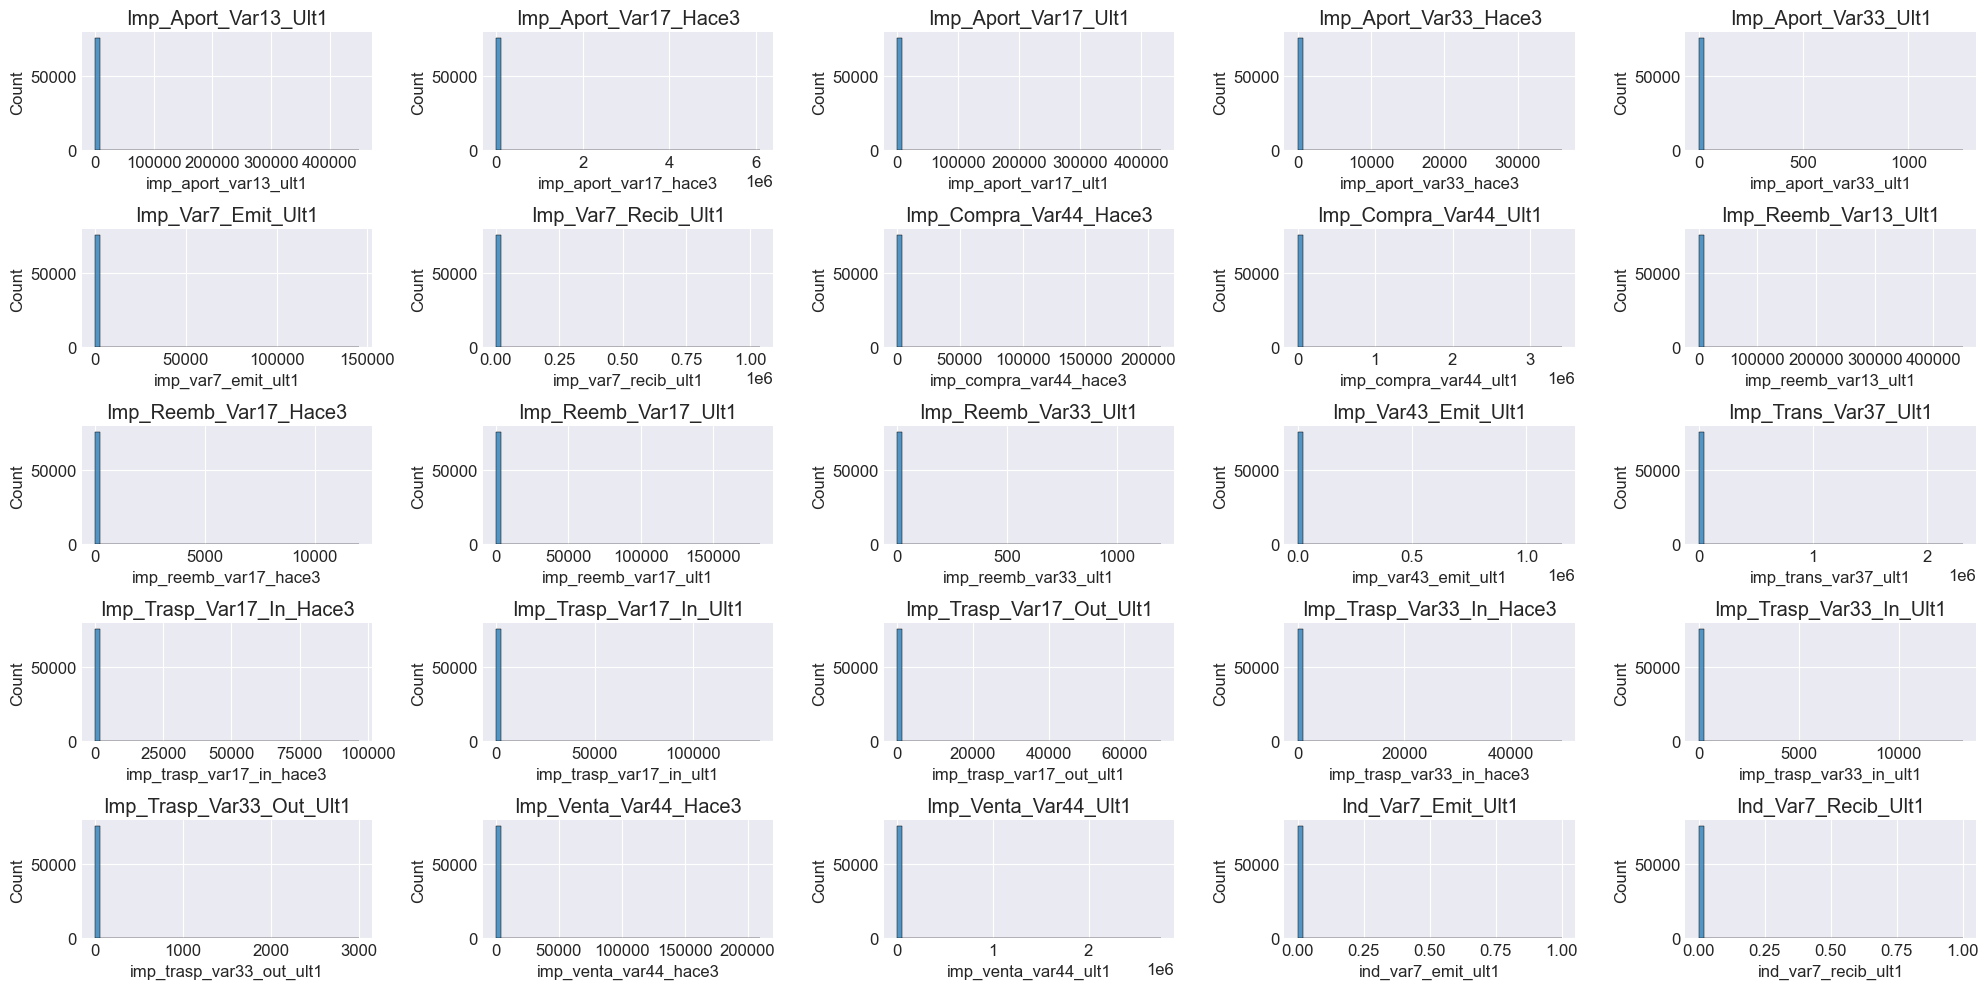

In [88]:
fig,axes= plt.subplots(5,5, figsize=(20,10))
axes = axes.ravel()
for count , col in enumerate(num_cols[from_range:to_range]):
    ax=axes[count]
    sns.histplot(feature_df, x=col, ax=ax , bins=50)
    ax.set_title(col.title())
plt.tight_layout()

In [90]:
from_range = 200
to_range=225
feature_df[num_cols[from_range:to_range]].describe().T

,count,mean,std,min,25%,50%,75%,max
ind_var10_ult1,76020.0,0.080873,0.272642,0.0,0.0,0.0,0.0,1.0
ind_var10cte_ult1,76020.0,0.092160,0.289254,0.0,0.0,0.0,0.0,1.0
ind_var9_cte_ult1,76020.0,0.096869,0.295782,0.0,0.0,0.0,0.0,1.0
ind_var9_ult1,76020.0,0.085912,0.280235,0.0,0.0,0.0,0.0,1.0
ind_var43_emit_ult1,76020.0,0.066588,0.249308,0.0,0.0,0.0,0.0,1.0
ind_var43_recib_ult1,76020.0,0.129308,0.335543,0.0,0.0,0.0,0.0,1.0
var21,76020.0,32.549329,393.834939,0.0,0.0,0.0,0.0,30000.0
num_aport_var13_hace3,76020.0,0.075888,0.552499,0.0,0.0,0.0,0.0,24.0
num_aport_var13_ult1,76020.0,0.017956,0.288757,0.0,0.0,0.0,0.0,30.0
num_aport_var17_hace3,76020.0,0.001539,0.104919,0.0,0.0,0.0,0.0,12.0


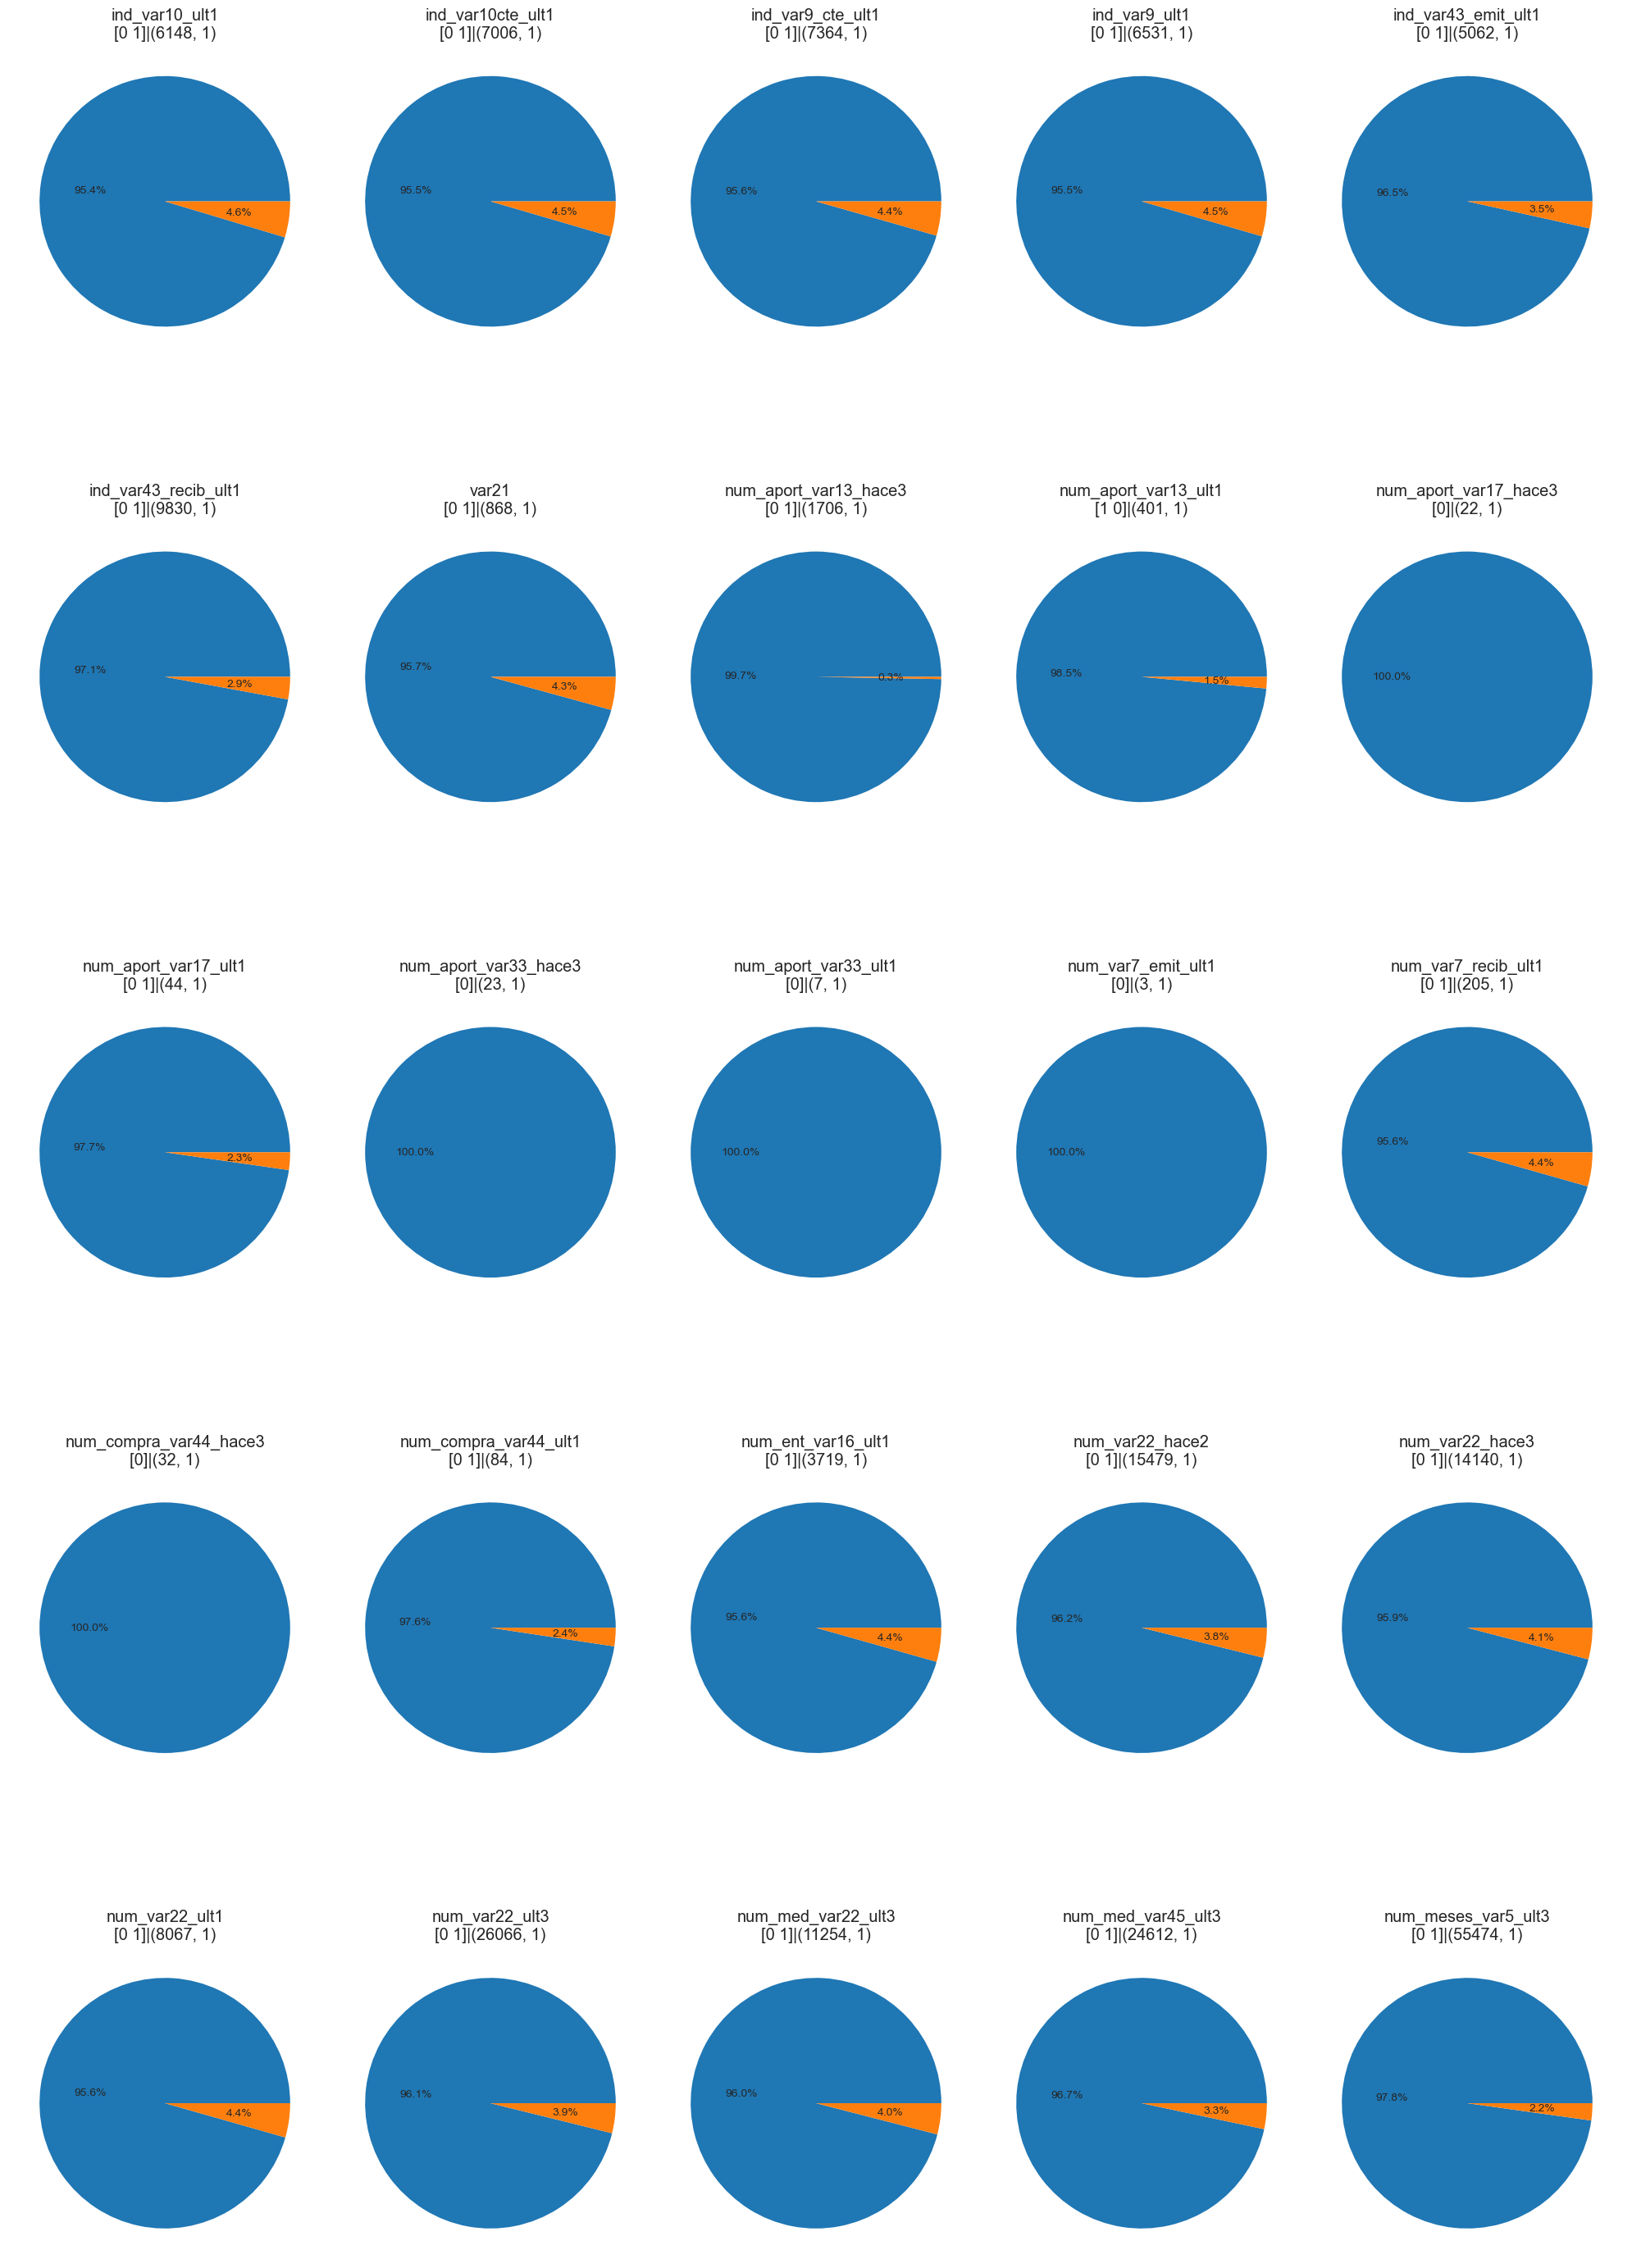

In [92]:
fig,axes= plt.subplots(5,5, figsize=(20,30))
axes = axes.ravel()
for count , col in enumerate(num_cols[from_range:to_range]):
    ax=axes[count]
    tmp_df= labels[feature_df[col]!=0]
    u_title=tmp_df['TARGET'].unique()
    shape=tmp_df.shape
    ax.pie(tmp_df['TARGET'].value_counts(), autopct='%1.1f%%')
    ax.set_title(f'{col}\n{u_title}|{shape}')
plt.tight_layout()

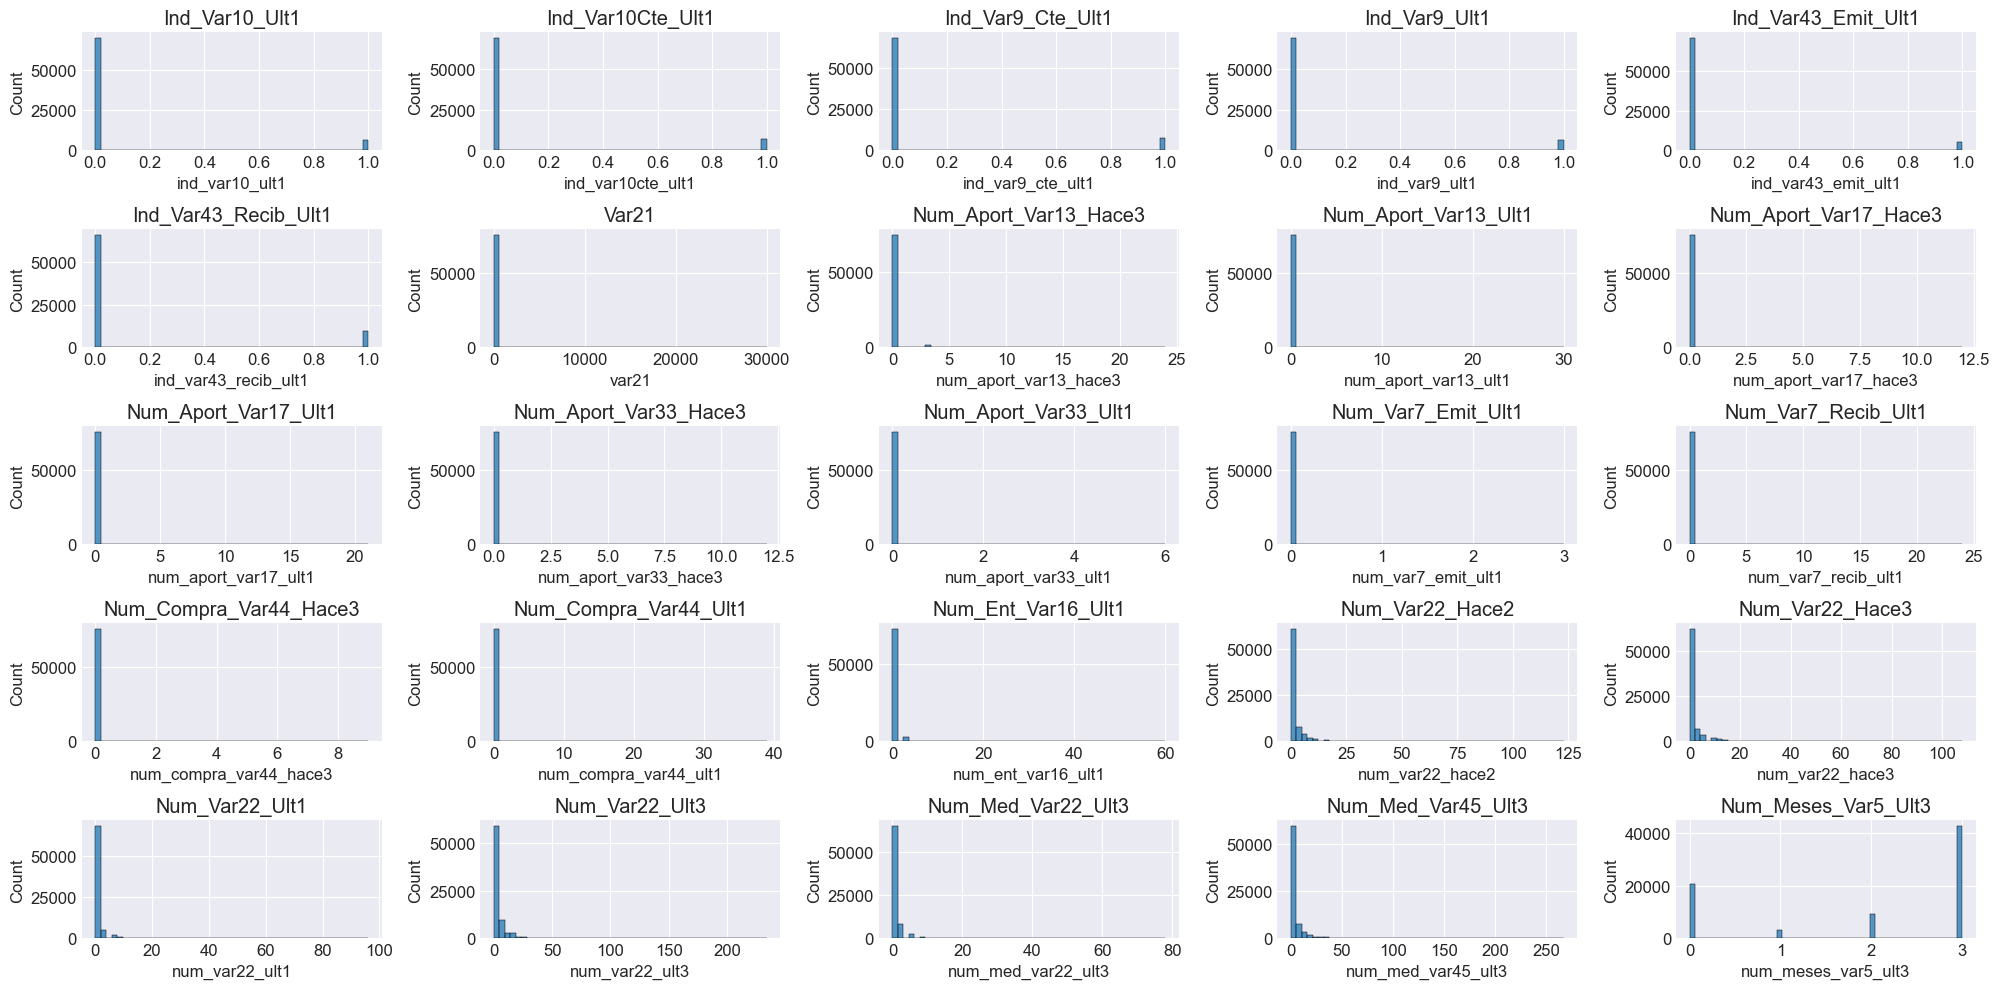

In [96]:
fig,axes= plt.subplots(5,5, figsize=(20,10))
axes = axes.ravel()
for count , col in enumerate(num_cols[from_range:to_range]):
    ax=axes[count]
    sns.histplot(feature_df, x=col, ax=ax , bins=50)
    ax.set_title(col.title())
plt.tight_layout()

In [24]:
X_train , X_test , y_train, y_test = train_test_split(feature_df,labels,
                                                      stratify=labels, test_size= TEST_SIZE, random_state = RANDOM_STATE)
X_train.shape, X_test.shape , y_train.shape, y_test.shape

((60816, 307), (15204, 307), (60816, 1), (15204, 1))

In [25]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test= scaler.transform(X_test)

In [26]:
clf = xgb.XGBClassifier(tree_method= 'hist',
                        n_jobs=16,
                        random_state = RANDOM_STATE)
clf

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=16,
              num_parallel_tree=None, random_state=24, ...)

In [27]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc= accuracy_score(y_test,y_pred)
acc

0.981978426729808

In [28]:
clf

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=16,
              num_parallel_tree=None, random_state=24, ...)

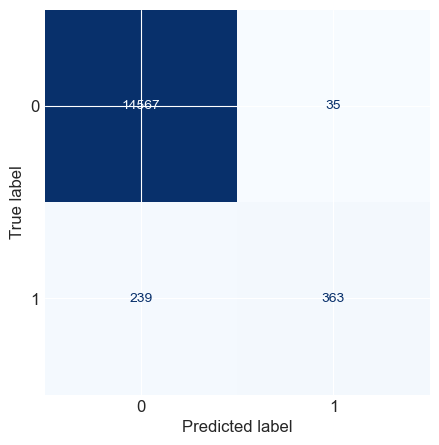

In [29]:
cm=confusion_matrix(y_true=y_test, y_pred=y_pred)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= class_names)
disp.plot(cmap=plt.cm.Blues, colorbar= False)
plt.show()